In [26]:
# import the library
import torch
import numpy as np
import torch.nn as nn # all neural network
import torch.optim as optim # all optimization algorithm
import torch.nn.functional as F # non activation function
from torchvision import datasets, transforms # Download datasets, transform images
from torch.utils.data.sampler import SubsetRandomSampler
print("All library imported")

All library imported


# Process
1. Load & Visualize the data
2. Pre process the data
3. Define model using PyTorch
4. Train the model
5. Save the best model
6. Test the model

1. Load the dataset, ETL

In [27]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ),)]) # mean is 0.5, standard deviation 0.5

In [28]:
# load the data - train and test set
trainset = datasets.FashionMNIST('~/pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/pytorch/F_MNIST_data', download=True, train=False, transform=transform)
print('Data loaded')

Data loaded


In [29]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /root/pytorch/F_MNIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [30]:
testset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /root/pytorch/F_MNIST_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [31]:
# partition train data, validation data, test data
indices = list(range(len(trainset)))
np.random.shuffle(indices)

# 20% of train set - validation set
split = int(np.floor(0.8 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

# data loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sample)
validloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=valid_sample)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

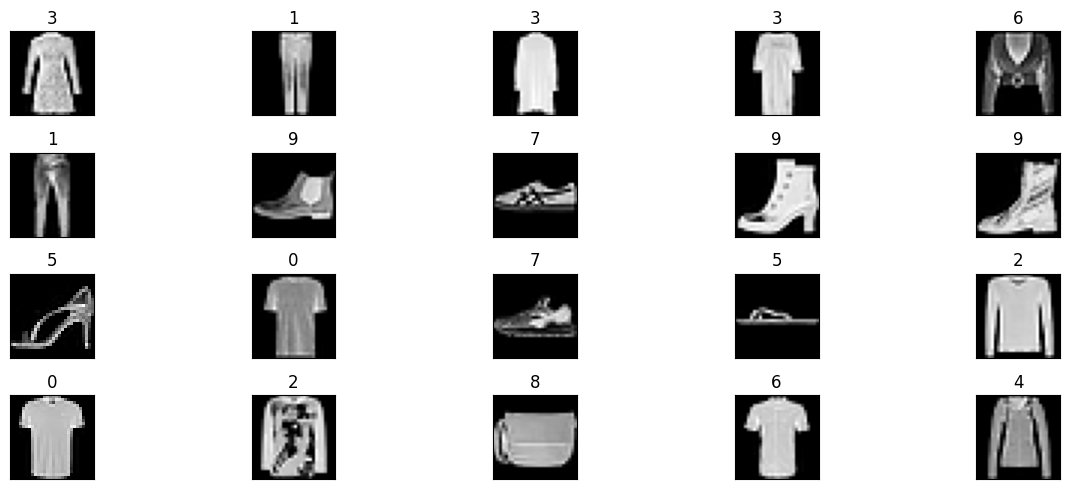

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

# get some random training images
dataiter = iter(trainloader)
print(dataiter)

images, labels = next(dataiter)

fig = plt.figure(figsize=(15, 5))
for idx in np.arange(20):
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(labels[idx].item())
  fig.tight_layout()

In [33]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

# Create ANN in pytorch

In [34]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 120)
    self.fc3 = nn.Linear(120, 10)
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    x = x.view(x.shape[0], -1) # flatten into 1D tensor
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    #output layer
    x = F.log_softmax(self.fc3(x), dim=1)
    return x

In [35]:
model = Classifier()
print(model)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [36]:
# define the loss function
criterion = nn.NLLLoss() # negative log likelyhood loss function
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
valid_loss_min = np.Inf
epochs = 10
steps = 0
train_losses, valid_losses = [], []

In [38]:
for e in range(epochs):
  running_loss = 0
  valid_loss = 0
  # to train the model
  for images, labels in trainloader:
    optimizer.zero_grad()
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * images.size(0)

  for images, labels in validloader:
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    valid_loss += loss.item() * images.size(0)

  running_loss = running_loss/len(trainloader.sampler)
  valid_loss = valid_loss/len(validloader.sampler)

  train_losses.append(running_loss)
  valid_losses.append(valid_loss)

  print('Epoch:{} \t Training Loss:{:.6f} \t validation Loss:{:.6f}'.
          format(e+1, running_loss, valid_loss))

  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}). Saving Model ... '.format(valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'model.pt')
    valid_loss_min = valid_loss

Epoch:1 	 Training Loss:0.574539 	 validation Loss:0.478851
Validation loss decreased (inf --> 0.478851). Saving Model ... 
Epoch:2 	 Training Loss:0.423360 	 validation Loss:0.417011
Validation loss decreased (0.478851 --> 0.417011). Saving Model ... 
Epoch:3 	 Training Loss:0.386070 	 validation Loss:0.383361
Validation loss decreased (0.417011 --> 0.383361). Saving Model ... 
Epoch:4 	 Training Loss:0.363389 	 validation Loss:0.390397
Epoch:5 	 Training Loss:0.345883 	 validation Loss:0.383993
Epoch:6 	 Training Loss:0.331778 	 validation Loss:0.360235
Validation loss decreased (0.383361 --> 0.360235). Saving Model ... 
Epoch:7 	 Training Loss:0.316976 	 validation Loss:0.353890
Validation loss decreased (0.360235 --> 0.353890). Saving Model ... 
Epoch:8 	 Training Loss:0.308464 	 validation Loss:0.356399
Epoch:9 	 Training Loss:0.299337 	 validation Loss:0.387046
Epoch:10 	 Training Loss:0.292115 	 validation Loss:0.347839
Validation loss decreased (0.353890 --> 0.347839). Saving M

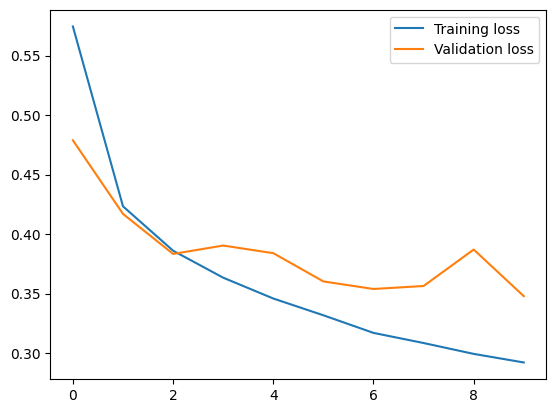

In [39]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')

plt.legend()

In [43]:
overall_train_loss = np.mean(train_losses)
overall_valid_loss = np.mean(valid_losses)

print('Overall Training Loss: {:.6f}'.format(overall_train_loss))
print('Overall Validation Loss: {:.6f}'.format(overall_valid_loss))

Overall Training Loss: 0.364191
Overall Validation Loss: 0.385902
